In [35]:

# LSTM Time Series Prediction for Query Count
# Predicting total_queries_count using PyTorch LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.7.1
CUDA available: False


In [36]:
print("\n" + "="*60)
print("STEP 1: DATA LOADING AND PREPROCESSING")
print("="*60)

# Load the dataset
df = pd.read_csv('./datasets/askalon_ee_trace_smoothed.csv', sep=',')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Sort by timestamp to ensure proper time series order
df['ts_submit_dt2'] = pd.to_datetime(df['ts_submit_dt2'])
df = df.sort_values('ts_submit_dt2').reset_index(drop=True)

print(f"\nTime range: {df['ts_submit_dt'].min()} to {df['ts_submit_dt'].max()}")
print(f"Total queries count range: {df['total_queries_count'].min()} to {df['total_queries_count'].max()}")

# Basic statistics
print("\nDataset Statistics:")
print(df[['total_queries_count', 'max_concurrent_tasks', 'aggregation_queries_count']].describe())


STEP 1: DATA LOADING AND PREPROCESSING
Dataset shape: (3552, 7)
Columns: ['ts_submit_dt2', 'max_concurrent_tasks', 'aggregation_queries_count', 'id', 'total_queries_count', 'ts_submit', 'ts_submit_dt']

Time range: 2006-09-19 22:37:54.716 to 2007-10-24 03:18:18.716
Total queries count range: 25 to 1152

Dataset Statistics:
       total_queries_count  max_concurrent_tasks  aggregation_queries_count
count          3552.000000           3552.000000                3552.000000
mean            367.258446             20.747748                  66.326014
std             229.765209             45.649411                  54.200802
min              25.000000              1.000000                   2.000000
25%             211.000000              1.000000                  25.000000
50%             334.000000              5.000000                  56.000000
75%             400.000000             17.000000                  93.000000
max            1152.000000           1002.000000                 2


STEP 2: EXPLORATORY DATA ANALYSIS


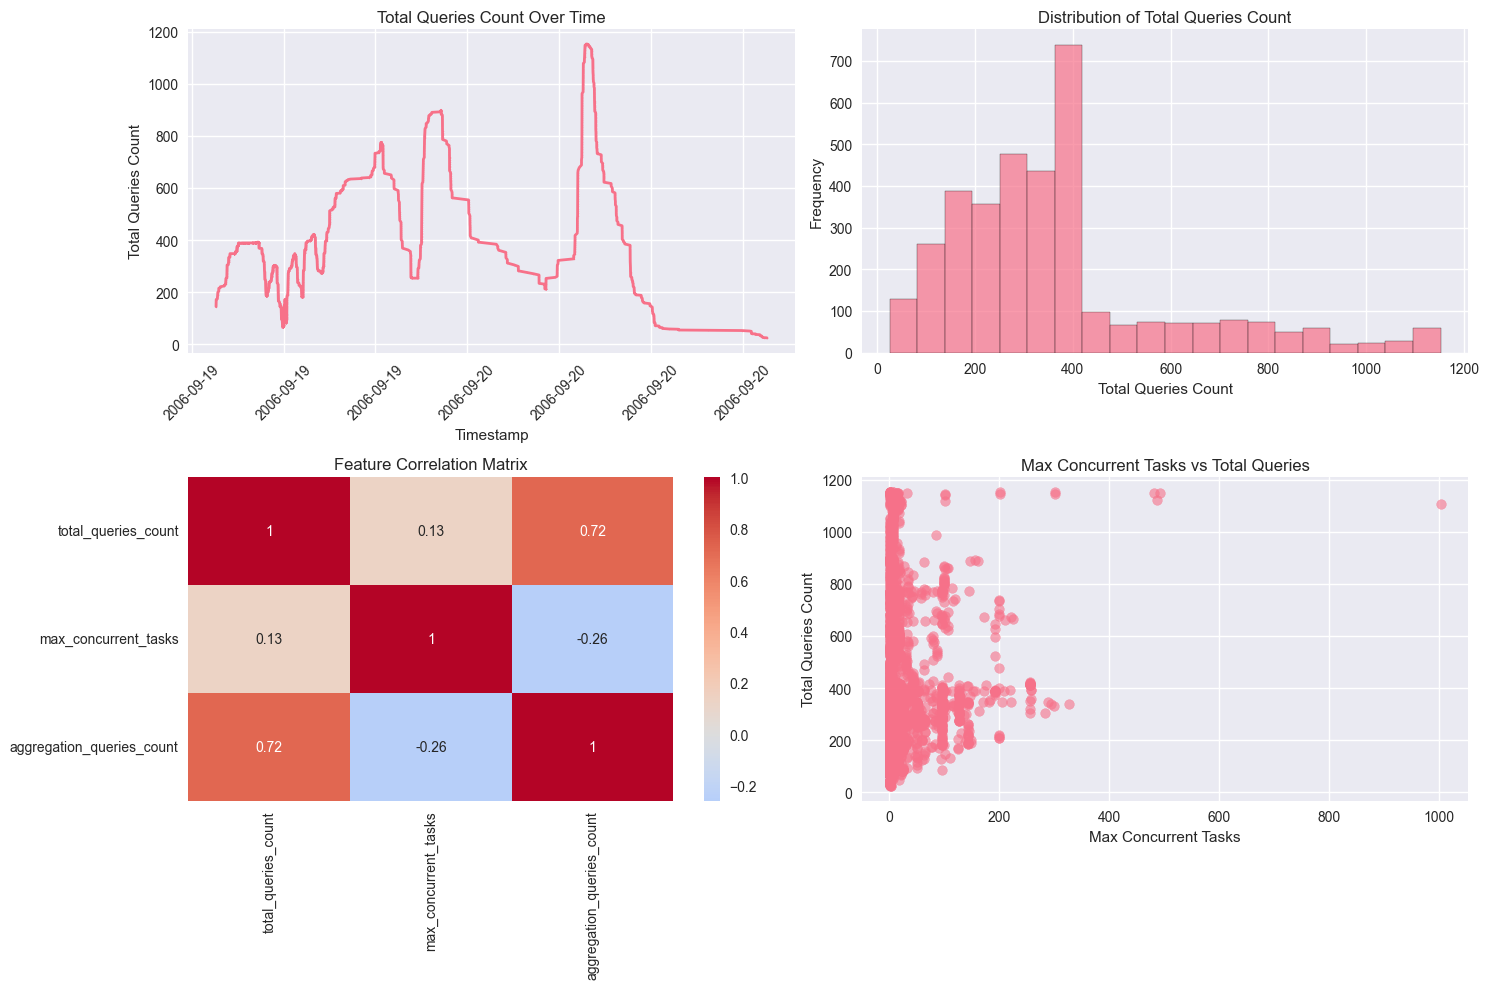

In [37]:
print("\n" + "="*60)
print("STEP 2: EXPLORATORY DATA ANALYSIS")
print("="*60)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Total queries count over time
step = len(df) // 10  # Adjust 10 to the number of ticks you want
xticks = df['ts_submit_dt2'][::step]

axes[0, 0].plot(df['ts_submit_dt2'], df['total_queries_count'],marker='o', linewidth=2, markersize=1)
axes[0, 0].set_title('Total Queries Count Over Time')
axes[0, 0].set_xlabel('Timestamp')
axes[0, 0].set_ylabel('Total Queries Count')
axes[0, 0].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0, 0].tick_params(axis='x', rotation=45)


# Plot 2: Distribution of total queries count
axes[0, 1].hist(df['total_queries_count'], bins=20, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribution of Total Queries Count')
axes[0, 1].set_xlabel('Total Queries Count')
axes[0, 1].set_ylabel('Frequency')

# Plot 3: Correlation with other features
corr_data = df[['total_queries_count', 'max_concurrent_tasks', 'aggregation_queries_count']].corr()
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, ax=axes[1, 0])
axes[1, 0].set_title('Feature Correlation Matrix')

# Plot 4: Max concurrent tasks vs total queries
axes[1, 1].scatter(df['max_concurrent_tasks'], df['total_queries_count'], alpha=0.6)
axes[1, 1].set_xlabel('Max Concurrent Tasks')
axes[1, 1].set_ylabel('Total Queries Count')
axes[1, 1].set_title('Max Concurrent Tasks vs Total Queries')

plt.tight_layout()
plt.show()

In [38]:
print("\n" + "="*60)
print("STEP 3: DATA PREPARATION FOR LSTM")
print("="*60)

# Extract the target variable
data = df['total_queries_count'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        #Input sequence
        X.append(data[i:(i+seq_length)])
        #Target value
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length (how many previous time steps to use for prediction)
SEQUENCE_LENGTH = 10  # Use last X time steps to predict the next one

X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

print(f"Input sequences shape: {X.shape}")
print(f"Target values shape: {y.shape}")
print(f"Each input sequence has {SEQUENCE_LENGTH} time steps")

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


STEP 3: DATA PREPARATION FOR LSTM
Input sequences shape: (3542, 10, 1)
Target values shape: (3542, 1)
Each input sequence has 10 time steps

Training set: 2833 samples
Test set: 709 samples


In [39]:
print("\n" + "="*60)
print("STEP 4: PYTORCH DATASET AND DATALOADER")
print("="*60)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

#Create datasets
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

#Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {BATCH_SIZE}")


STEP 4: PYTORCH DATASET AND DATALOADER
Training batches: 89
Test batches: 23
Batch size: 32


In [40]:
print("\n" + "="*60)
print("STEP 5: LSTM MODEL DEFINITION")
print("="*60)

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
            dropout = dropout
        )

        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        #initialize hidden state
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)

        #LSTM forward pass
        lstm_out, _ = self.lstm(x, (h0, c0))

        #Get last output
        last_output = lstm_out[:, -1, :]

        #Linear layer
        predictions = self.linear(last_output)
        return predictions

#Model parameters
INPUT_SIZE = 1      #Number of features (just 1, total_queries_count)
HIDDEN_SIZE = 32    #Number of LSTM units
NUM_LAYERS = 3      #Number of LSTM layers
OUTPUT_SIZE = 1     #Number of output features (predicting total_queries_count)

#Create Model
model = LSTMModel(
    input_size = INPUT_SIZE,
    hidden_size = HIDDEN_SIZE,
    num_layers = NUM_LAYERS,
    output_size = OUTPUT_SIZE
)

print(f"Model created successfully!")
print(f"Model parameters:")
print(f"- Input size: {INPUT_SIZE}")
print(f"- Hidden size: {HIDDEN_SIZE}")
print(f"- Number of layers: {NUM_LAYERS}")
print(f"- Output size: {OUTPUT_SIZE}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"- Total parameters: {total_params}")
print(f"- Trainable parameters: {trainable_params}")


STEP 5: LSTM MODEL DEFINITION
Model created successfully!
Model parameters:
- Input size: 1
- Hidden size: 32
- Number of layers: 3
- Output size: 1
- Total parameters: 21409
- Trainable parameters: 21409


In [41]:
print("\n" + "="*60)
print("STEP 6: TRAINING SETUP")
print("="*60)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
NUM_EPOCHS = 50
PRINT_EVERY = 10

print(f"Training configuration:")
print(f"- Loss function: MSE")
print(f"- Optimizer: Adam")
print(f"- Learning rate: 0.001")
print(f"- Number of epochs: {NUM_EPOCHS}")


STEP 6: TRAINING SETUP
Training configuration:
- Loss function: MSE
- Optimizer: Adam
- Learning rate: 0.001
- Number of epochs: 50


In [42]:
print("\n" + "="*60)
print("STEP 7: MODEL TRAINING WITH EARLY STOPPING")
print("="*60)

# Training loop with early stopping
train_losses = []
val_losses = []

best_val_loss = float('inf')
patience = 10           # Stop if no improvement after 10 epochs
counter = 0
early_stop = False

# To restore the best model later
best_model_state = None

model.train()
for epoch in range(NUM_EPOCHS):
    if early_stop:
        print(f"\nEarly stopping triggered at epoch {epoch+1}: Best validation loss: {best_val_loss:.6f}")
        break

    # Training phase
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y.squeeze())
            val_loss += loss.item()

    model.train()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            early_stop = True

    # Print progress
    if (epoch + 1) % PRINT_EVERY == 0 or early_stop:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

print("\nTraining completed!")


STEP 7: MODEL TRAINING WITH EARLY STOPPING
Epoch 10/50, Train Loss: 0.000203, Val Loss: 0.002778
Epoch 20/50, Train Loss: 0.000193, Val Loss: 0.004553
Epoch 21/50, Train Loss: 0.000164, Val Loss: 0.004571

Early stopping triggered at epoch 22: Best validation loss: 0.002698

Training completed!



STEP 8: TRAINING VISUALIZATION


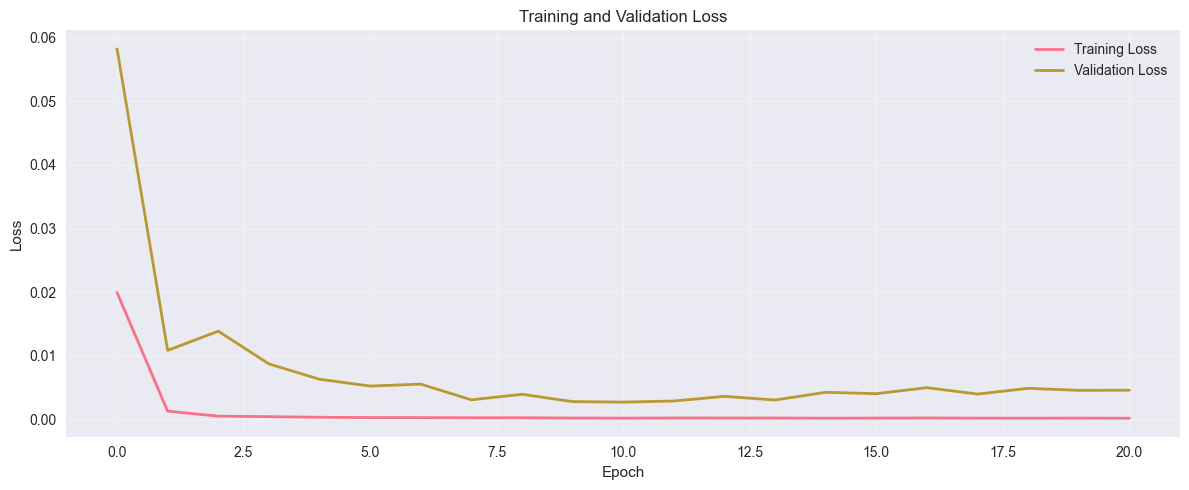

In [43]:
print("\n" + "="*60)
print("STEP 8: TRAINING VISUALIZATION")
print("="*60)

# Plot training and validation losses
plt.figure(figsize=(12, 5))

plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [44]:
print("\n" + "="*60)
print("STEP 9: MAKING PREDICTIONS")
print("="*60)

#Make predictions on test set
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        predictions.extend(outputs.squeeze().numpy())
        actuals.extend(batch_y.squeeze().numpy())

predictions = np.array(predictions).reshape(-1, 1)
actuals = np.array(actuals).reshape(-1, 1)

#Inverse transform the predictions and actuals
predictions_original = scaler.inverse_transform(predictions)
actuals_original = scaler.inverse_transform(actuals)

print(f"Made predictions for {len(predictions)} samples in the test set")

#Calculate metrics
mse = mean_squared_error(actuals_original, predictions_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals_original, predictions_original)

print(f"\nModel Performance Metrics:")
print(f"- Mean Squared Error (MSE): {mse:.2f}")
print(f"- Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"- Mean Absolute Error (MAE): {mae:.2f}")


STEP 9: MAKING PREDICTIONS
Made predictions for 709 samples in the test set

Model Performance Metrics:
- Mean Squared Error (MSE): 6026.32
- Root Mean Squared Error (RMSE): 77.63
- Mean Absolute Error (MAE): 53.99



STEP 10: RESULTS VISUALIZATION


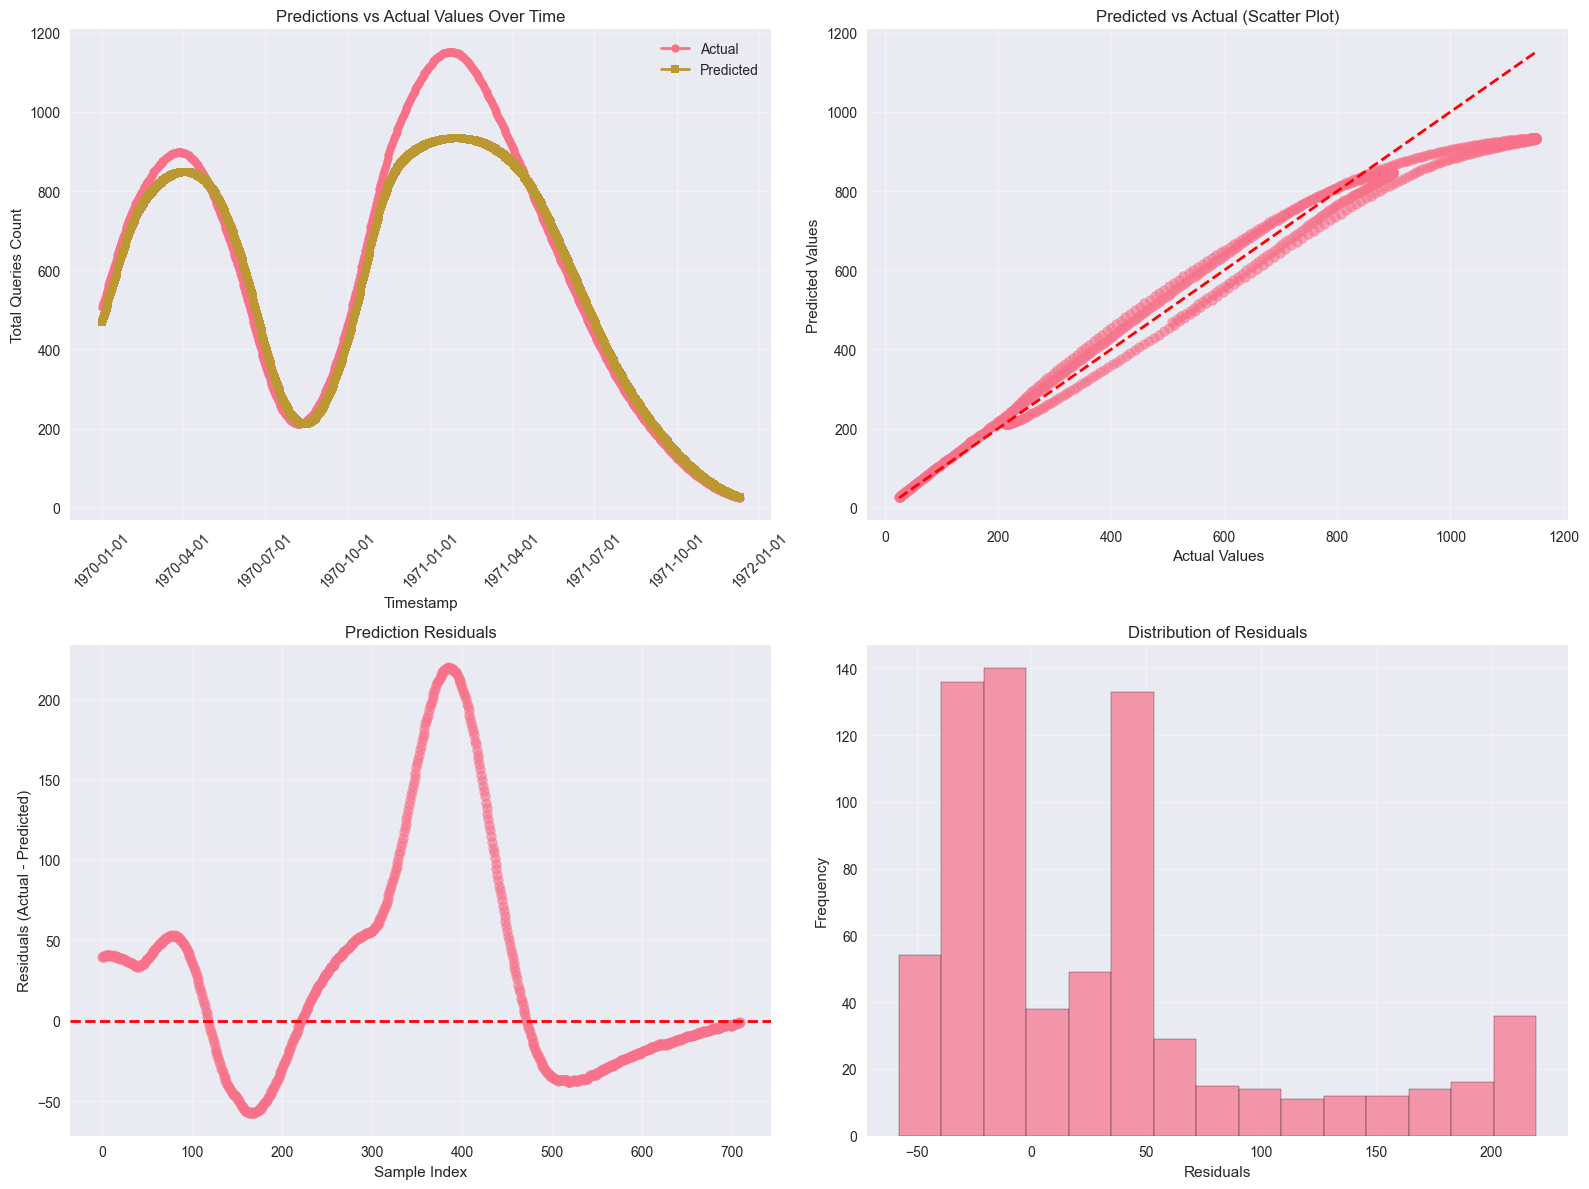

In [45]:
print("\n" + "="*60)
print("STEP 10: RESULTS VISUALIZATION")
print("="*60)

# Get the corresponding timestamps for test data
test_start_idx = train_size + SEQUENCE_LENGTH
test_timestamps = df['ts_submit_dt'].iloc[test_start_idx:test_start_idx + len(predictions)]

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Predictions vs Actual (line plot)
xticks = test_timestamps[::10]
axes[0, 0].plot(test_timestamps, actuals_original, 'o-', label='Actual', linewidth=2, markersize=6)
axes[0, 0].plot(test_timestamps, predictions_original, 's-', label='Predicted', linewidth=2, markersize=6)
axes[0, 0].set_title('Predictions vs Actual Values Over Time')
axes[0, 0].set_xlabel('Timestamp')
axes[0, 0].set_ylabel('Total Queries Count')
axes[0, 0].legend()
axes[0, 0].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Scatter plot of predictions vs actual
axes[0, 1].scatter(actuals_original, predictions_original, alpha=0.6, s=50)
axes[0, 1].plot([actuals_original.min(), actuals_original.max()], 
               [actuals_original.min(), actuals_original.max()], 'r--', linewidth=2)
axes[0, 1].set_xlabel('Actual Values')
axes[0, 1].set_ylabel('Predicted Values')
axes[0, 1].set_title('Predicted vs Actual (Scatter Plot)')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals (prediction errors)
residuals = actuals_original - predictions_original
axes[1, 0].scatter(range(len(residuals)), residuals, alpha=0.6, s=50)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 0].set_title('Prediction Residuals')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Residuals distribution
axes[1, 1].hist(residuals, bins=15, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [46]:
# Save only the model parameters (state_dict)
torch.save(model.state_dict(), "lstm_model.pth")

In [ ]:
saved_model = LSTMModel(
    input_size = INPUT_SIZE,
    hidden_size = HIDDEN_SIZE,
    num_layers = NUM_LAYERS,
    output_size = OUTPUT_SIZE
)

saved_model.load_state_dict(torch.load("lstm_model.pth"))
saved_model.eval()

new_df = pd.read_csv('./datasets/galaxy_trace.csv', sep=',')

In [48]:
# Complete the notebook with testing on new data
print("\n" + "="*60)
print("STEP 11: TESTING SAVED MODEL ON NEW DATA")
print("="*60)

# Load and examine the new dataset
print(f"New dataset shape: {new_df.shape}")
print(f"New dataset columns: {list(new_df.columns)}")

# Check if the new dataset has the same structure
if 'total_queries_count' not in new_df.columns:
    print("ERROR: 'total_queries_count' column not found in new dataset!")
    print("Available columns:", list(new_df.columns))
else:
    print(f"Time range in new data: {new_df['ts_submit_dt'].min()} to {new_df['ts_submit_dt'].max()}")
    print(f"Total queries count range: {new_df['total_queries_count'].min()} to {new_df['total_queries_count'].max()}")

# Sort by timestamp to ensure proper time series order
new_df = new_df.sort_values('ts_submit_dt').reset_index(drop=True)

print("\nNew Dataset Statistics:")
print(new_df[['total_queries_count']].describe())



STEP 11: TESTING SAVED MODEL ON NEW DATA
New dataset shape: (3552, 10)
New dataset columns: ['Unnamed: 0', 'max_concurrent_tasks', 'aggregation_queries_count', 'id', 'total_queries_count', 'ts_submit', 'ts_submit_dt', 'elapsed_time', 'scaled_elapsed_time', 'ts_submit_dt2']
Time range in new data: 2006-09-19 22:37:54.716 to 2007-10-24 03:18:18.716
Total queries count range: 1 to 1203

New Dataset Statistics:
       total_queries_count
count          3552.000000
mean             34.316160
std              74.614775
min               1.000000
25%               1.000000
50%               8.000000
75%              29.000000
max            1203.000000


In [49]:
print("\n" + "="*60)
print("STEP 12: PREPARE NEW DATA FOR PREDICTION")
print("="*60)

# Extract the target variable from new data
new_data = new_df['total_queries_count'].values.reshape(-1, 1)

# IMPORTANT: Use the same scaler that was fitted on training data
# We need to transform the new data using the same scaling parameters
new_scaled_data = scaler.transform(new_data)

print(f"New data shape after scaling: {new_scaled_data.shape}")

# Create sequences for the new data
# We need at least SEQUENCE_LENGTH points to start making predictions
if len(new_scaled_data) < SEQUENCE_LENGTH:
    print(f"ERROR: New dataset has only {len(new_scaled_data)} points, but we need at least {SEQUENCE_LENGTH} points to make predictions!")
else:
    new_X, new_y = create_sequences(new_scaled_data, SEQUENCE_LENGTH)
    print(f"New input sequences shape: {new_X.shape}")
    print(f"New target values shape: {new_y.shape}")



STEP 12: PREPARE NEW DATA FOR PREDICTION
New data shape after scaling: (3552, 1)
New input sequences shape: (3542, 10, 1)
New target values shape: (3542, 1)


In [50]:
print("\n" + "="*60)
print("STEP 13: MAKE PREDICTIONS ON NEW DATA")
print("="*60)

# Make predictions using the saved model
saved_model.eval()
new_predictions = []
new_actuals = []

# Convert to tensors for prediction
new_X_tensor = torch.FloatTensor(new_X)
new_y_tensor = torch.FloatTensor(new_y)

with torch.no_grad():
    # Process in batches to handle memory efficiently
    batch_size = 32
    for i in range(0, len(new_X_tensor), batch_size):
        batch_X = new_X_tensor[i:i+batch_size]
        batch_y = new_y_tensor[i:i+batch_size]
        
        outputs = saved_model(batch_X)
        new_predictions.extend(outputs.squeeze().numpy())
        new_actuals.extend(batch_y.squeeze().numpy())

new_predictions = np.array(new_predictions).reshape(-1, 1)
new_actuals = np.array(new_actuals).reshape(-1, 1)

# Inverse transform to get original scale
new_predictions_original = scaler.inverse_transform(new_predictions)
new_actuals_original = scaler.inverse_transform(new_actuals)

print(f"Made predictions for {len(new_predictions)} samples in the new dataset")

# Calculate metrics for new data
new_mse = mean_squared_error(new_actuals_original, new_predictions_original)
new_rmse = np.sqrt(new_mse)
new_mae = mean_absolute_error(new_actuals_original, new_predictions_original)

print(f"\nModel Performance on New Data:")
print(f"- Mean Squared Error (MSE): {new_mse:.2f}")
print(f"- Root Mean Squared Error (RMSE): {new_rmse:.2f}")
print(f"- Mean Absolute Error (MAE): {new_mae:.2f}")


STEP 13: MAKE PREDICTIONS ON NEW DATA
Made predictions for 3542 samples in the new dataset

Model Performance on New Data:
- Mean Squared Error (MSE): 5515.67
- Root Mean Squared Error (RMSE): 74.27
- Mean Absolute Error (MAE): 36.52



STEP 14: VISUALIZE PREDICTIONS ON NEW DATA


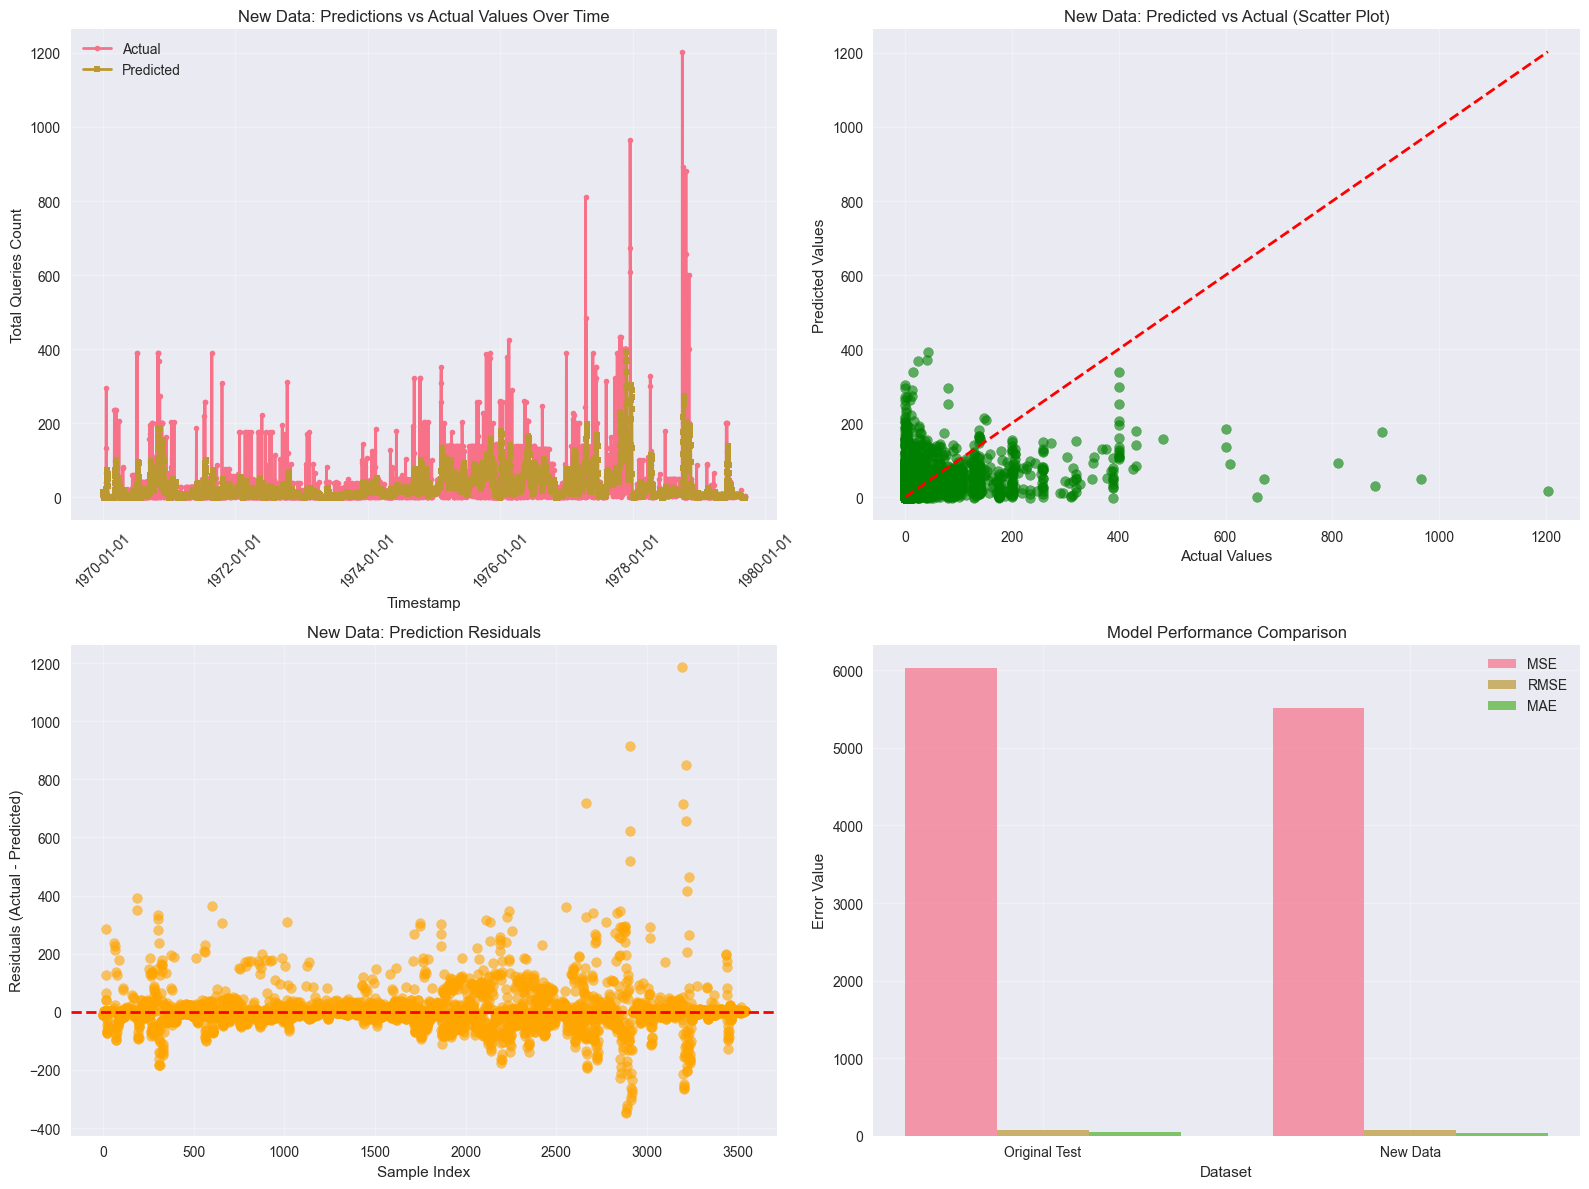

In [51]:
print("\n" + "="*60)
print("STEP 14: VISUALIZE PREDICTIONS ON NEW DATA")
print("="*60)

# Get corresponding timestamps for new data predictions
new_test_start_idx = SEQUENCE_LENGTH
new_test_timestamps = new_df['ts_submit_dt'].iloc[new_test_start_idx:new_test_start_idx + len(new_predictions)]

# Create visualization for new data predictions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Predictions vs Actual for new data
axes[0, 0].plot(new_test_timestamps, new_actuals_original, 'o-', label='Actual', linewidth=2, markersize=4)
axes[0, 0].plot(new_test_timestamps, new_predictions_original, 's-', label='Predicted', linewidth=2, markersize=4)
axes[0, 0].set_title('New Data: Predictions vs Actual Values Over Time')
axes[0, 0].set_xlabel('Timestamp')
axes[0, 0].set_ylabel('Total Queries Count')
axes[0, 0].legend()
axes[0, 0].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Scatter plot for new data
axes[0, 1].scatter(new_actuals_original, new_predictions_original, alpha=0.6, s=50, color='green')
axes[0, 1].plot([new_actuals_original.min(), new_actuals_original.max()], 
               [new_actuals_original.min(), new_actuals_original.max()], 'r--', linewidth=2)
axes[0, 1].set_xlabel('Actual Values')
axes[0, 1].set_ylabel('Predicted Values')
axes[0, 1].set_title('New Data: Predicted vs Actual (Scatter Plot)')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals for new data
new_residuals = new_actuals_original - new_predictions_original
axes[1, 0].scatter(range(len(new_residuals)), new_residuals, alpha=0.6, s=50, color='orange')
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 0].set_title('New Data: Prediction Residuals')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Comparison of model performance
metrics_comparison = {
    'Dataset': ['Original Test', 'New Data'],
    'MSE': [mse, new_mse],
    'RMSE': [rmse, new_rmse],
    'MAE': [mae, new_mae]
}

x_pos = np.arange(len(metrics_comparison['Dataset']))
width = 0.25

axes[1, 1].bar(x_pos - width, metrics_comparison['MSE'], width, label='MSE', alpha=0.7)
axes[1, 1].bar(x_pos, metrics_comparison['RMSE'], width, label='RMSE', alpha=0.7)
axes[1, 1].bar(x_pos + width, metrics_comparison['MAE'], width, label='MAE', alpha=0.7)

axes[1, 1].set_xlabel('Dataset')
axes[1, 1].set_ylabel('Error Value')
axes[1, 1].set_title('Model Performance Comparison')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(metrics_comparison['Dataset'])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()